### Comparing kernel matrices with different approaches

In [32]:
using Flux,LinearAlgebra,CairoMakie,Random,ProgressMeter
Random.seed!(123)

TaskLocalRNG()

In [33]:
include("DenseNTK.jl")
include("normNTK.jl")

kernel (generic function with 2 methods)

We start by making a model using DenseNTK that works like Dense in Flux but is more general in a sense of calculating the kernel


In [34]:
Nh = 1000
model = Chain(DenseNTK(1=>Nh,relu),DenseNTK(Nh=>1))|>f64
θ = Flux.params(model)
Nx = 40
xa = -1.0
xb = 1.0
xR = range(xa,stop=xb,length=Nx) 
x = hcat(xR...)


1×40 Matrix{Float64}:
 -1.0  -0.948718  -0.897436  -0.846154  …  0.846154  0.897436  0.948718  1.0

In [35]:

K_i = zeros(Float64,3*Nh+1,Nx)
@showprogress for i = 1:Nx
    ∇_SIE = Flux.gradient(()-> model([x[i]])[1],θ)
    K_i[1:Nh,i] = ∇_SIE[θ[1]][:]
    K_i[Nh+1:2*Nh,i] = ∇_SIE[θ[2]][:]
    K_i[2*Nh+1:3*Nh,i] = ∇_SIE[θ[3]][:]
    K_i[3*Nh+1:3*Nh+1,i] = ∇_SIE[θ[4]][:] 
end

Kernel_SIE = K_i[1:3*Nh,:]'*K_i[1:3*Nh,:]
# eigen(Kernel_SIE).values

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


40×40 Matrix{Float64}:
 2.06304   2.00541   1.94846   1.89151   …  0.319605  0.302278  0.285925
 2.00541   1.95632   1.9021    1.84787      0.33482   0.318203  0.302223
 1.94846   1.9021    1.86058   1.80896      0.35099   0.334971  0.319255
 1.89151   1.84787   1.80896   1.77158      0.368143  0.352706  0.337237
 1.83155   1.79069   1.75445   1.71972      0.386952  0.372098  0.356876
 1.75342   1.71572   1.68253   1.65083   …  0.406017  0.391933  0.377147
 1.68133   1.64659   1.61624   1.58738      0.431662  0.417845  0.40299
 1.60509   1.57334   1.54587   1.51987      0.451634  0.438784  0.424563
 1.53968   1.51066   1.4858    1.4624       0.476356  0.464222  0.450382
 1.48374   1.45723   1.43477   1.41375      0.499417  0.48826   0.475062
 ⋮                                       ⋱                      
 0.448307  0.459319  0.47195   0.485663     1.50588   1.53513   1.55497
 0.423916  0.435762  0.449118  0.463538     1.56249   1.59443   1.61662
 0.398753  0.411165  0.424975  0.439834

In [36]:
K = kernel(model,x,true)


Computing kernel: 100%|██████████████████████████████████████████████████| Time: 0:00:02


40×40 Matrix{Float64}:
 2.06304   2.00541   1.94846   1.89151   …  0.319605  0.302278  0.285925
 2.00541   1.95632   1.9021    1.84787      0.33482   0.318203  0.302223
 1.94846   1.9021    1.86058   1.80896      0.35099   0.334971  0.319255
 1.89151   1.84787   1.80896   1.77158      0.368143  0.352706  0.337237
 1.83155   1.79069   1.75445   1.71972      0.386952  0.372098  0.356876
 1.75342   1.71572   1.68253   1.65083   …  0.406017  0.391933  0.377147
 1.68133   1.64659   1.61624   1.58738      0.431662  0.417845  0.40299
 1.60509   1.57334   1.54587   1.51987      0.451634  0.438784  0.424563
 1.53968   1.51066   1.4858    1.4624       0.476356  0.464222  0.450382
 1.48374   1.45723   1.43477   1.41375      0.499417  0.48826   0.475062
 ⋮                                       ⋱                      
 0.448307  0.459319  0.47195   0.485663     1.50588   1.53513   1.55497
 0.423916  0.435762  0.449118  0.463538     1.56249   1.59443   1.61662
 0.398753  0.411165  0.424975  0.439834

In [37]:
round.(K[:,:],digits=13)==round.(Kernel_SIE[:,:],digits=13)

true

In [38]:
# eigen(Kernel_SIE).values
λ = eigen(K).values
λ = abs.(λ)
λ = sort!(λ)



for i = 1:Nx
    if λ[i] == 0
        λ[i] = 10^(-19)
    end
end

λ

40-element Vector{Float64}:
  0.0021951710846612386
  0.002260083947237412
  0.0023739888748214575
  0.0030287906860339657
  0.0031000357276724758
  0.003391509063537893
  0.003996978091600115
  0.004009839779322954
  0.004221754925469283
  0.004826119271525094
  ⋮
  0.04825434929051143
  0.06312462715032072
  0.07757989757335812
  0.13268728464605145
  0.22209272744037817
  0.44207883756596195
  1.589489259976094
 13.767773333647797
 37.971668054366546

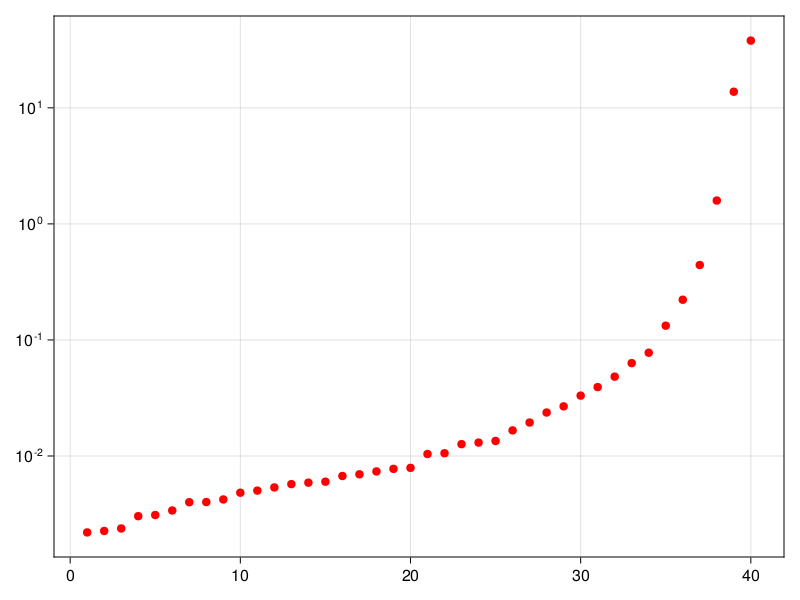

In [39]:
fig = Figure()
ax1 = Axis(fig[1,1],yscale=log10)
s1 = CairoMakie.scatter!(ax1,λ[:],color=:red)
fig


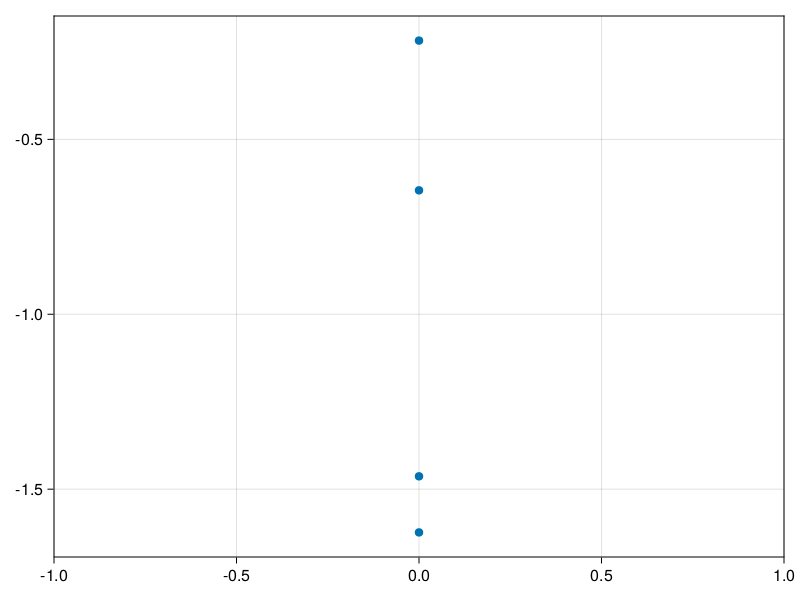

In [40]:
t = [0]
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,t,θ[1][1:4])
fig



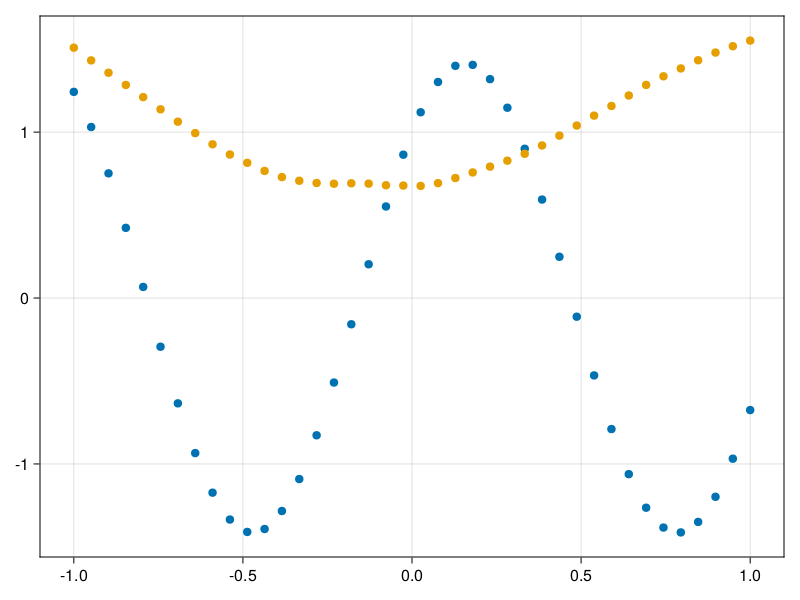

In [41]:
x_train = x
f = x->sin(5*x)+cos(5*x)
y_train = map(f,x_train)
y_hat = model(x_train)
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,x_train[:],y_train[:])
CairoMakie.scatter!(ax1,x_train[:],y_hat[:])
fig


In [42]:
y_train_hat = model(x_train)
Loss(model,x,y) = Flux.mse(y,model(x))
loss = Loss(model,x_train,y_train)
train_data = [(x_train,y_train)]
display(loss)



2.6301074343479565

In [43]:

train_data = [(x_train,y_train)]
η = (1/λ[end])
Nepoch = 50_000
L = []


layer = 3
θ_stop = 6
θ_s = zeros(Nepoch,θ_stop)
@showprogress for epoch = 1:Nepoch
    Flux.train!(Loss,model,train_data,Descent(η))
    for i = 1:θ_stop
        θ_s[epoch,i] = Flux.params(model)[layer][i]
    end
        
    push!(L,Loss(model,x_train,y_train))
end



Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


In [44]:
L = hcat(L...)

1×50000 Matrix{Float64}:
 2.34465  2.11415  1.92787  1.77715  …  0.0152412  0.0152408  0.0152405

In [45]:
t = 1:Nepoch
dt = hcat(t...)



1×50000 Matrix{Int64}:
 1  2  3  4  5  6  7  8  9  10  11  12  …  49996  49997  49998  49999  50000

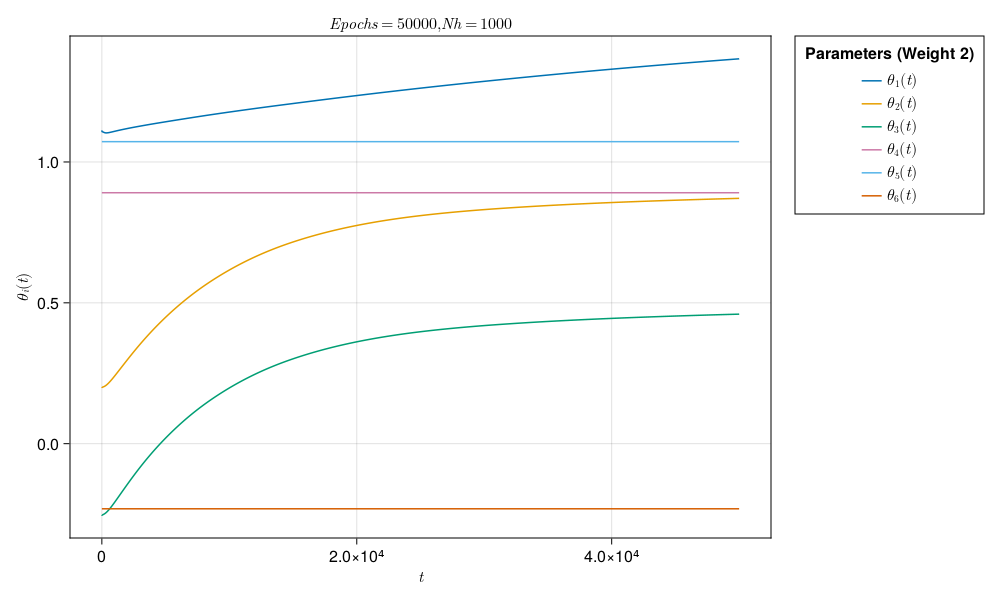

In [46]:
fig = Figure(resolution=(1000, 600))

# Creating a grid layout for the figure: 1 row, 2 columns
# The first column for the plot, the second for the legend
grid = fig[1, 1] = GridLayout()
ax1 = Axis(grid[1, 1], title=L"Epochs = %$Nepoch, Nh = %$Nh", xlabel=L"t", ylabel=L"θ_i(t)")

# Plotting data
for i = 1:θ_stop
    lines!(ax1, dt[:], θ_s[:,i], label=L"θ_{%$i}(t)")
end

# Adjusting the layout to leave space for the legend outside the plot
grid[1, 2] = Legend(fig, ax1, "Parameters (Weight 2)", valign=:top, orientation=:vertical)


fig

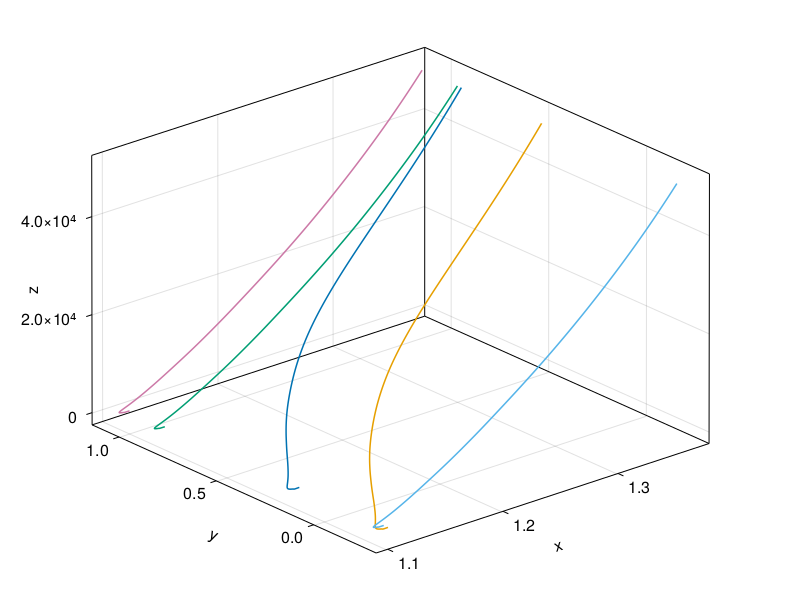

In [47]:
fig = Figure()

ax3d = Axis3(fig[1,1])

for i = 2:θ_stop
    CairoMakie.lines!(θ_s[:,1],θ_s[:,i],dt[:],label=L"%$i")
end


fig

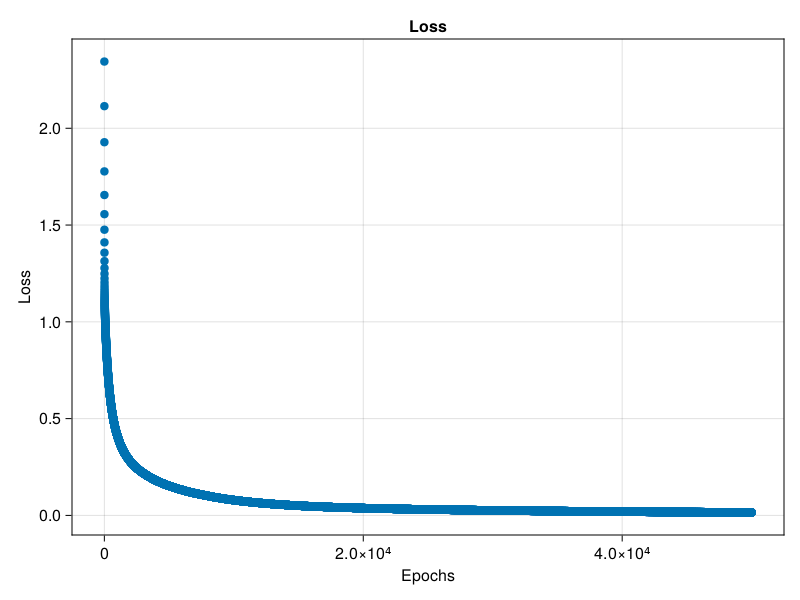

In [48]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Loss",xlabel="Epochs",ylabel="Loss")
CairoMakie.scatter!(ax1,dt[:],L[:])


fig


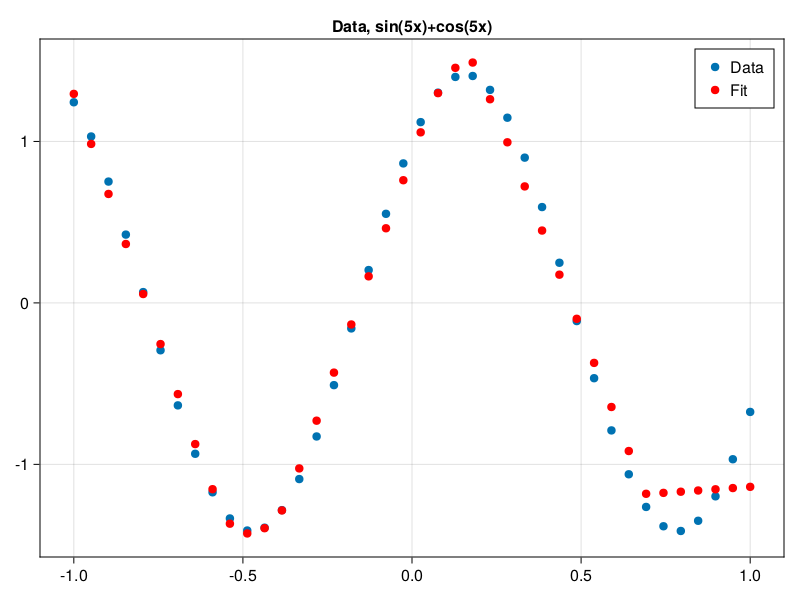

In [49]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Data, sin(5x)+cos(5x)")
CairoMakie.scatter!(ax1,x_train[:],y_train[:],label="Data")
CairoMakie.scatter!(ax1,x_train[:],model(x_train)[:],color=:red,label="Fit")
axislegend(ax1,position=:rt)
fig


In [50]:
# using CairoMakie
# using FileIO

# # Define the function to create a plot frame
# function create_frame(epoch, θ_s, L, frame_number)
#     fig = Figure(resolution = (1000, 600))
#     grid = fig[1, 1] = GridLayout()
#     ax1 = Axis(grid[1, 1], title = "Model Parameters over Epochs", xlabel = "Epoch", ylabel = "Parameter Value")

#     # Plot parameter changes up to the current epoch
#     for i = 1:size(θ_s, 2)  # Assuming θ_s has dimensions [epoch, parameter]
#         lines!(ax1, 1:epoch, θ_s[1:epoch, i], label = "θ_$i")
#     end

#     # Adjusting layout for legend, if needed
#     # grid[1, 2] = Legend(fig, ax1, "Parameters", valign = :top, orientation = :vertical)

#     # Save the frame
#     filename = string("frame_", lpad(frame_number, 4, '0'), ".png")
#     save(filename, fig)
# end

# # Assuming your training loop and data collection are already set up
# # Inside your training loop, at certain intervals, call `create_frame`
# frame_number = 1
# for epoch = 1:Nepoch
#     # Your training and data collection code here

#     if epoch % 100 == 0  # Adjust the interval as needed
#         create_frame(epoch, θ_s, L, frame_number)
#         frame_number += 1
#     end
# end

# # After training, compile the frames into a GIF
# frames = [string("frame_", lpad(i, 4, '0'), ".png") for i = 1:frame_number-1]
# gif_filename = "parameter_changes.gif"
# save(gif_filename, frames, fps = 10)  # Adjust fps as needed


In [51]:
# train_data = [(x_train,y_train)]
# η = 1/λ[end]
# Nepoch = 50000
# L = []


# @showprogress for epoch = 1:Nepoch
#     Flux.train!(Loss,model,train_data,Descent(η))
#     push!(L,Loss(model,x_train,y_train))
# end

In [52]:
# N = 10
# l = [2.02; 1.08; 0.9; 0.01]
# e_vec = []

# # Calculate e_vec based on l
# for ls in l
#     e = N / ls
#     push!(e_vec, e)
# end

# for i in 1:N
#     element = findCorrespondingElement(i, e_vec, l)
#     if !isnothing(element)
#         println("Iteration $i calls element $element from vectorB")
#     else
#         println("Iteration $i exceeds all thresholds")
#     end
#     # Here you can do something with `element`
# end


In [53]:
# Nepoch = 500
# epoch_vec = []
# for λs in λ
#     Δ = Nepoch/λs
#     push!(epoch_vec,Δ)
# end
# epoch_vec = sort!(epoch_vec)
# train_data = [(x_train,y_train)]
# Loss(model,x,y) = Flux.mse(y,model(x))
# L = []

# loss = Loss(model,x_train,y_train)
# λ = sort!(λ,rev=true)
# @showprogress for epoch = 1:Nepoch
#     # Determine the index for λ based on the current epoch
#     index = findfirst(threshold -> epoch <= threshold, epoch_vec)
#     index = isnothing(index) ? length(λ) : index  # Use the last λ if beyond all thresholds
    
#     η = 1 / λ[index]  # Update learning rate based on the current epoch range
    
#     display(η)
#     # # Train the model with the updated learning rate
#     Flux.train!(Loss, model, train_data, Descent(η))
    
#     # # Record the loss
#     # push!(L, Loss(model, x_train, y_train))
# end

